In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
from os.path import expanduser

In [2]:
PROTON_MASS = 1.00727647
ADD_C_CYSTEINE_DA = 57.021464

In [3]:
# calculate the monoisotopic mass    
def calculate_monoisotopic_mass_from_mz(monoisotopic_mz, charge):
    monoisotopic_mass = (monoisotopic_mz * charge) - (PROTON_MASS * charge)
    return monoisotopic_mass

In [4]:
experiment_name = 'P3830'
run_name = 'P3830_YeastUPS2_01_Slot1-1_1_5082'
experiment_base_dir = '/media/big-ssd/experiments'

In [5]:
EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)
MQ_PERCOLATOR_OUTPUT_DIR = '{}/percolator-output-maxquant'.format(EXPERIMENT_DIR)
MQ_MGF_DIR = '{}/mgf-maxquant'.format(EXPERIMENT_DIR)

In [6]:
MAXIMUM_Q_VALUE = 0.01

In [7]:
# load the percolator output
MQ_PERCOLATOR_OUTPUT_FILE_NAME = "{}/{}.percolator.target.psms.txt".format(MQ_PERCOLATOR_OUTPUT_DIR, experiment_name)
mq_psms_df = pd.read_csv(MQ_PERCOLATOR_OUTPUT_FILE_NAME, sep='\t')
mq_psms_df.rename(columns={'scan': 'mq_index'}, inplace=True)
mq_psms_df.drop(['charge'], axis=1, inplace=True)
# remove the poor quality identifications
mq_psms_df = mq_psms_df[mq_psms_df['peptide mass'] > 0]

In [8]:
mq_psms_df.columns

Index(['file_idx', 'mq_index', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa'],
      dtype='object')

In [9]:
# merge the precolator results with the MQ features - obtained with the -v flag of the APL-to-MGF converter
MQ_FEATURES_NAME = '{}/{}.pkl'.format(MQ_MGF_DIR, run_name)
mq_features_df = pd.read_pickle(MQ_FEATURES_NAME)

In [10]:
mq_features_df.columns

Index(['monoisotopic_mass', 'charge', 'monoisotopic_mz', 'intensity',
       'scan_apex', 'rt_apex', 'raw_file', 'mq_index', 'ms2_peaks'],
      dtype='object')

In [11]:
mq_identifications_df = pd.merge(mq_features_df, mq_psms_df, how='left', left_on=['mq_index'], right_on=['mq_index'])
# remove any features that were not identified
mq_identifications_df.dropna(subset=['sequence'], inplace=True)


In [12]:
mq_identifications_df['theoretical_peptide_mass'] = mq_identifications_df['peptide mass'] + (mq_identifications_df.sequence.str.count('C') * ADD_C_CYSTEINE_DA)
mq_identifications_df['mass_accuracy_ppm'] = (mq_identifications_df['monoisotopic_mass'] - mq_identifications_df['theoretical_peptide_mass']) / mq_identifications_df['theoretical_peptide_mass'] * 10**6
mq_identifications_df['mass_error'] = mq_identifications_df['monoisotopic_mass'] - mq_identifications_df['theoretical_peptide_mass']


In [13]:
mq_identifications_df.columns

Index(['monoisotopic_mass', 'charge', 'monoisotopic_mz', 'intensity',
       'scan_apex', 'rt_apex', 'raw_file', 'mq_index', 'ms2_peaks', 'file_idx',
       'spectrum precursor m/z', 'spectrum neutral mass', 'peptide mass',
       'percolator score', 'percolator q-value', 'percolator PEP',
       'total matches/spectrum', 'sequence', 'protein id', 'flanking aa',
       'theoretical_peptide_mass', 'mass_accuracy_ppm', 'mass_error'],
      dtype='object')

In [14]:
mq_identifications_df = mq_identifications_df[(mq_identifications_df['percolator q-value'] <= MAXIMUM_Q_VALUE) & (~mq_identifications_df['protein id'].str.contains('YEAST'))]

In [15]:
print('number of unique proteins: {}'.format(len(mq_identifications_df['protein id'].unique())))

number of unique proteins: 20


#### using the Top3 approach to determine protein quanitification

In [16]:
ups2_proteins_l = []

ups2_proteins_l.append({'uniprot':'P00915', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P00918', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P01031', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P69905', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P68871', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P41159', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P02768', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P62988', 'fmoles':50000})

ups2_proteins_l.append({'uniprot':'P04040', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P00167', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P01133', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P02144', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P15559', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P62937', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'Q06830', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P63165', 'fmoles':5000})

ups2_proteins_l.append({'uniprot':'P00709', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P06732', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P12081', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P61626', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'Q15843', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P02753', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P16083', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P63279', 'fmoles':500})

ups2_proteins_l.append({'uniprot':'P01008', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P61769', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P55957', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'O76070', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P08263', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P01344', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P01127', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P10599', 'fmoles':50})

ups2_proteins_l.append({'uniprot':'P99999', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P06396', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P09211', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P01112', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P01579', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P02787', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'O00762', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P51965', 'fmoles':5})

ups2_proteins_l.append({'uniprot':'P08758', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P02741', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P05413', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P10145', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P02788', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P10636-8', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P00441', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P01375', 'fmoles':0.5})

ups2_d = {}
for p in ups2_proteins_l:
    ups2_d[p['uniprot']] = p['fmoles']

In [17]:
mq_identifications_df['protein id'].unique()

array(['P02768ups|ALBU_HUMAN_UPS', 'P00918ups|CAH2_HUMAN_UPS',
       'P00915ups|CAH1_HUMAN_UPS', 'P15559ups|NQO1_HUMAN_UPS',
       'P68871ups|HBB_HUMAN_UPS', 'P41159ups|LEP_HUMAN_UPS',
       'P63165ups|SUMO1_HUMAN_UPS', 'P04040ups|CATA_HUMAN_UPS',
       'P02144ups|MYG_HUMAN_UPS', 'P00167ups|CYB5_HUMAN_UPS',
       'P69905ups|HBA_HUMAN_UPS', 'P01031ups|CO5_HUMAN_UPS',
       'P12081ups|SYHC_HUMAN_UPS', 'P01579ups|IFNG_HUMAN_UPS',
       'Q06830ups|PRDX1_HUMAN_UPS', 'P00709ups|LALBA_HUMAN_UPS',
       'P62937ups|PPIA_HUMAN_UPS,P62988ups|UBIQ_HUMAN_UPS,O76070ups|SYUG_HUMAN_UPS',
       'P62988ups|UBIQ_HUMAN_UPS', 'P06732ups|KCRM_HUMAN_UPS',
       'P01133ups|EGF_HUMAN_UPS'], dtype=object)

In [18]:
# find the three most intense peptides for each protein
top3_l = []
for group_name,group_df in mq_identifications_df.groupby('protein id'):
    df = group_df.sort_values(by=['intensity'], ascending=False, inplace=False)
    top3_df = df.head(n=3)
    if len(top3_df) == 3:
        uniprot_id = group_name.split('ups')[0]
        pmoles = ups2_d[uniprot_id] / 1000
        average_intensity = top3_df.intensity.mean()
        signal_response_factor = average_intensity / pmoles
        peptide_count = len(df)
        attribs_d = top3_df[['mq_index','sequence','charge','intensity']].to_dict('records')
        top3_l.append({'protein':group_name, 'pmoles':pmoles, 'average_intensity':average_intensity, 'signal_response_factor':signal_response_factor, 'peptide_count':peptide_count, 'attribs_d':attribs_d})
    else:
        print('didn\'t have three peptides for {}'.format(group_name))
mq_top3_df = pd.DataFrame(top3_l)

didn't have three peptides for P00167ups|CYB5_HUMAN_UPS
didn't have three peptides for P00709ups|LALBA_HUMAN_UPS
didn't have three peptides for P01133ups|EGF_HUMAN_UPS
didn't have three peptides for P01579ups|IFNG_HUMAN_UPS
didn't have three peptides for P06732ups|KCRM_HUMAN_UPS
didn't have three peptides for P62937ups|PPIA_HUMAN_UPS,P62988ups|UBIQ_HUMAN_UPS,O76070ups|SYUG_HUMAN_UPS
didn't have three peptides for P62988ups|UBIQ_HUMAN_UPS
didn't have three peptides for P63165ups|SUMO1_HUMAN_UPS


In [19]:
# using Serum albumin (P02768) as an internal reference
universal_signal_response_factor = mq_top3_df[mq_top3_df.protein.str.startswith('P02768')].iloc[0].signal_response_factor
universal_signal_response_factor

130899.33333333334

In [20]:
mq_top3_df['calculated_pmoles'] = mq_top3_df.average_intensity / universal_signal_response_factor

In [21]:
mq_top3_df

,protein,pmoles,average_intensity,signal_response_factor,peptide_count,attribs_d,calculated_pmoles
0,P00915ups|CAH1_HUMAN_UPS,50.0,1.901467e+06,38029.333333,15,"[{'mq_index': 13373, 'sequence': 'HDTSLKPISVSY...",14.526175
1,P00918ups|CAH2_HUMAN_UPS,50.0,1.739333e+06,34786.666667,16,"[{'mq_index': 16798, 'sequence': 'YDPSLKPLSVSY...",13.287564
2,P01031ups|CO5_HUMAN_UPS,50.0,5.591990e+05,11183.980000,3,"[{'mq_index': 16942, 'sequence': 'CCYDGACVNNDE...",4.271977
3,P02144ups|MYG_HUMAN_UPS,5.0,1.772887e+05,35457.733333,5,"[{'mq_index': 7284, 'sequence': 'VEADIPGHGQEVL...",1.354389
4,P02768ups|ALBU_HUMAN_UPS,50.0,6.544967e+06,130899.333333,74,"[{'mq_index': 15443, 'sequence': 'VFDEFKPLVEEP...",50.000000
5,P04040ups|CATA_HUMAN_UPS,5.0,2.169767e+05,43395.333333,7,"[{'mq_index': 8854, 'sequence': 'GAGAFGYFEVTHD...",1.657584
6,P12081ups|SYHC_HUMAN_UPS,0.5,5.616700e+04,112334.000000,3,"[{'mq_index': 5825, 'sequence': 'HGAEVIDTPVFEL...",0.429085
7,P15559ups|NQO1_HUMAN_UPS,5.0,1.456790e+05,29135.800000,4,"[{'mq_index': 15586, 'sequence': 'LKDPANFQYPAE...",1.112909
8,P41159ups|LEP_HUMAN_UPS,50.0,1.225630e+06,24512.600000,14,"[{'mq_index': 13196, 'sequence': 'VTGLDFIPGLHP...",9.363149
9,P68871ups|HBB_HUMAN_UPS,50.0,1.219700e+06,24394.000000,11,"[{'mq_index': 8044, 'sequence': 'VLGAFSDGLAHLD...",9.317847


In [22]:
# calculate the CV for the signal response factor
cv = mq_top3_df.signal_response_factor.std() / mq_top3_df.signal_response_factor.mean()
cv

0.889434727594015

#### calculate correlation

In [23]:
mq_top3_df['pmoles'].corr(mq_top3_df['calculated_pmoles'])

0.5208846217405785

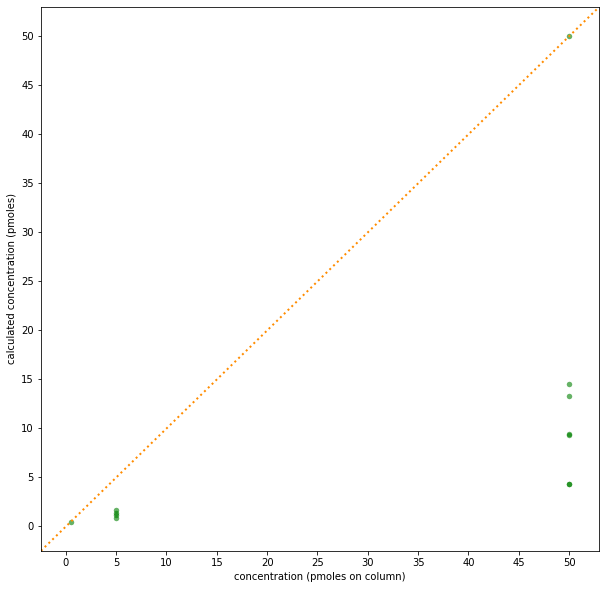

In [24]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('')

ax.scatter(mq_top3_df.pmoles, mq_top3_df.calculated_pmoles, marker='o', lw=0, s=30, alpha=0.6, c='green')

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

# plt.xlim((-1,55.0))
# plt.ylim((-1,55.0))

nearest = 5.0
range_l = round(mq_top3_df.pmoles.min() / nearest) * nearest
range_u = round(mq_top3_df.pmoles.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlabel('concentration (pmoles on column)')
plt.ylabel('calculated concentration (pmoles)')

plt.show()

#### relative quantification

In [37]:
# find the three most intense peptides for each protein
top3_l = []
for group_name,group_df in mq_identifications_df.groupby('protein id'):
    df = group_df.sort_values(by=['intensity'], ascending=False, inplace=False)
    top3_df = df.head(n=3)
    if len(top3_df) == 3:
        uniprot_id = group_name.split('ups')[0]
        pmoles = ups2_d[uniprot_id] / 1000
        average_intensity = top3_df.intensity.mean()
        peptide_count = len(df)
        attribs_d = top3_df[['mq_index','sequence','charge','intensity']].to_dict('records')
        top3_l.append({'protein':group_name, 'average_intensity':average_intensity, 'pmoles':pmoles, 'peptide_count':peptide_count, 'attribs_d':attribs_d})
    else:
        print('didn\'t have three peptides for {}'.format(group_name))
relative_mq_top3_df = pd.DataFrame(top3_l)

didn't have three peptides for P00167ups|CYB5_HUMAN_UPS
didn't have three peptides for P00709ups|LALBA_HUMAN_UPS
didn't have three peptides for P01133ups|EGF_HUMAN_UPS
didn't have three peptides for P01579ups|IFNG_HUMAN_UPS
didn't have three peptides for P06732ups|KCRM_HUMAN_UPS
didn't have three peptides for P62937ups|PPIA_HUMAN_UPS,P62988ups|UBIQ_HUMAN_UPS,O76070ups|SYUG_HUMAN_UPS
didn't have three peptides for P62988ups|UBIQ_HUMAN_UPS
didn't have three peptides for P63165ups|SUMO1_HUMAN_UPS


In [38]:
relative_mq_top3_df

,protein,average_intensity,pmoles,peptide_count,attribs_d
0,P00915ups|CAH1_HUMAN_UPS,1.901467e+06,50.0,15,"[{'mq_index': 13373, 'sequence': 'HDTSLKPISVSY..."
1,P00918ups|CAH2_HUMAN_UPS,1.739333e+06,50.0,16,"[{'mq_index': 16798, 'sequence': 'YDPSLKPLSVSY..."
2,P01031ups|CO5_HUMAN_UPS,5.591990e+05,50.0,3,"[{'mq_index': 16942, 'sequence': 'CCYDGACVNNDE..."
3,P02144ups|MYG_HUMAN_UPS,1.772887e+05,5.0,5,"[{'mq_index': 7284, 'sequence': 'VEADIPGHGQEVL..."
4,P02768ups|ALBU_HUMAN_UPS,6.544967e+06,50.0,74,"[{'mq_index': 15443, 'sequence': 'VFDEFKPLVEEP..."
5,P04040ups|CATA_HUMAN_UPS,2.169767e+05,5.0,7,"[{'mq_index': 8854, 'sequence': 'GAGAFGYFEVTHD..."
6,P12081ups|SYHC_HUMAN_UPS,5.616700e+04,0.5,3,"[{'mq_index': 5825, 'sequence': 'HGAEVIDTPVFEL..."
7,P15559ups|NQO1_HUMAN_UPS,1.456790e+05,5.0,4,"[{'mq_index': 15586, 'sequence': 'LKDPANFQYPAE..."
8,P41159ups|LEP_HUMAN_UPS,1.225630e+06,50.0,14,"[{'mq_index': 13196, 'sequence': 'VTGLDFIPGLHP..."
9,P68871ups|HBB_HUMAN_UPS,1.219700e+06,50.0,11,"[{'mq_index': 8044, 'sequence': 'VLGAFSDGLAHLD..."


In [36]:
reference_intensity = relative_mq_top3_df[relative_mq_top3_df.protein.str.startswith('P02768')].iloc[0].average_intensity
reference_intensity

6544966.666666667

In [42]:
reference_pmoles = relative_mq_top3_df[relative_mq_top3_df.protein.str.startswith('P02768')].iloc[0].pmoles
reference_pmoles

50.0

In [43]:
relative_mq_top3_df['intensity_factor'] = relative_mq_top3_df.average_intensity / reference_intensity
relative_mq_top3_df['expected_intensity_factor'] = relative_mq_top3_df.pmoles / reference_pmoles

In [44]:
relative_mq_top3_df

,protein,average_intensity,pmoles,peptide_count,attribs_d,intensity_factor,expected_intensity_factor
0,P00915ups|CAH1_HUMAN_UPS,1.901467e+06,50.0,15,"[{'mq_index': 13373, 'sequence': 'HDTSLKPISVSY...",0.290524,1.00
1,P00918ups|CAH2_HUMAN_UPS,1.739333e+06,50.0,16,"[{'mq_index': 16798, 'sequence': 'YDPSLKPLSVSY...",0.265751,1.00
2,P01031ups|CO5_HUMAN_UPS,5.591990e+05,50.0,3,"[{'mq_index': 16942, 'sequence': 'CCYDGACVNNDE...",0.085440,1.00
3,P02144ups|MYG_HUMAN_UPS,1.772887e+05,5.0,5,"[{'mq_index': 7284, 'sequence': 'VEADIPGHGQEVL...",0.027088,0.10
4,P02768ups|ALBU_HUMAN_UPS,6.544967e+06,50.0,74,"[{'mq_index': 15443, 'sequence': 'VFDEFKPLVEEP...",1.000000,1.00
5,P04040ups|CATA_HUMAN_UPS,2.169767e+05,5.0,7,"[{'mq_index': 8854, 'sequence': 'GAGAFGYFEVTHD...",0.033152,0.10
6,P12081ups|SYHC_HUMAN_UPS,5.616700e+04,0.5,3,"[{'mq_index': 5825, 'sequence': 'HGAEVIDTPVFEL...",0.008582,0.01
7,P15559ups|NQO1_HUMAN_UPS,1.456790e+05,5.0,4,"[{'mq_index': 15586, 'sequence': 'LKDPANFQYPAE...",0.022258,0.10
8,P41159ups|LEP_HUMAN_UPS,1.225630e+06,50.0,14,"[{'mq_index': 13196, 'sequence': 'VTGLDFIPGLHP...",0.187263,1.00
9,P68871ups|HBB_HUMAN_UPS,1.219700e+06,50.0,11,"[{'mq_index': 8044, 'sequence': 'VLGAFSDGLAHLD...",0.186357,1.00


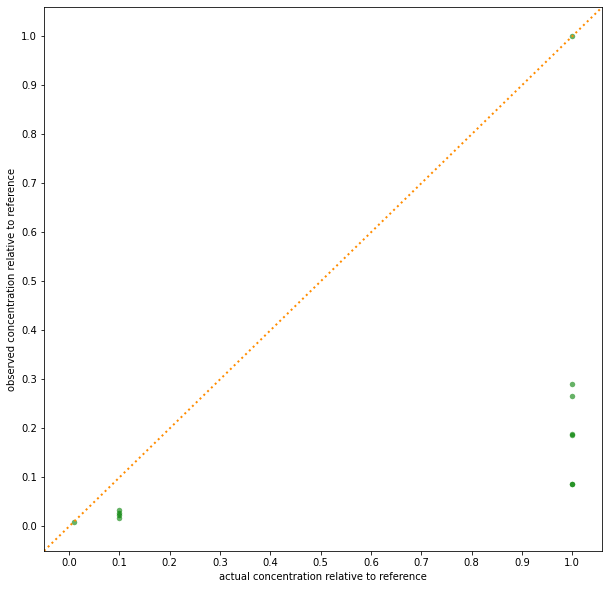

In [46]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('')

ax.scatter(relative_mq_top3_df.expected_intensity_factor, relative_mq_top3_df.intensity_factor, marker='o', lw=0, s=30, alpha=0.6, c='green')

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

# plt.xlim((-1,55.0))
# plt.ylim((-1,55.0))

nearest = 0.1
range_l = round(relative_mq_top3_df.expected_intensity_factor.min() / nearest) * nearest
range_u = round(relative_mq_top3_df.expected_intensity_factor.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlabel('actual concentration relative to reference')
plt.ylabel('observed concentration relative to reference')

plt.show()

#### how many proteins does MaxQuant find with Andromeda

In [25]:
MQ_ANALYSIS_DIR = '{}/MQ-analysis-of-P3830/combined/txt'.format(expanduser('~'))

In [26]:
mq_results_df = pd.read_csv('{}/evidence.txt'.format(MQ_ANALYSIS_DIR), sep='\\t', engine='python')

In [27]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [28]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]
# remove yeast proteins
mq_results_df = mq_results_df[(~mq_results_df['Proteins'].str.contains('YEAST'))]


In [29]:
mq_results_df.sample(n=10)[['Proteins','Leading proteins']]

,Proteins,Leading proteins
35110,sp|O76070|SYUG_HUMAN,sp|O76070|SYUG_HUMAN
97488,sp|P00918|CAH2_HUMAN,sp|P00918|CAH2_HUMAN
174778,sp|P41159|LEP_HUMAN,sp|P41159|LEP_HUMAN
52564,sp|P08758|ANXA5_HUMAN,sp|P08758|ANXA5_HUMAN
61467,sp|P02144|MYG_HUMAN,sp|P02144|MYG_HUMAN
35708,sp|P01008|ANT3_HUMAN,sp|P01008|ANT3_HUMAN
15372,sp|P02787|TRFE_HUMAN,sp|P02787|TRFE_HUMAN
152504,sp|Q6ZMV9|KIF6_HUMAN,sp|Q6ZMV9|KIF6_HUMAN
93937,sp|P68871|HBB_HUMAN;CON__Q3SX09;sp|P02042|HBD_...,sp|P68871|HBB_HUMAN;sp|P02042|HBD_HUMAN
88551,sp|P02787|TRFE_HUMAN,sp|P02787|TRFE_HUMAN


In [30]:
# definition of uniqueness in MaxQuant output with MBR on
proteins_l = []
unique_peptide_key = ['Sequence','Modifications','Charge']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key):
    protein = group_df.iloc[0]['Leading proteins']
    if len(group_df['Leading proteins'].unique()) > 1:
        print('more than one protein')
    proteins_l.append({'peptide':group_name, 'protein':protein})
mq_proteins_df = pd.DataFrame(proteins_l)

In [31]:
print('number of unique proteins: {}'.format(len(mq_proteins_df.protein.unique())))

number of unique proteins: 85
